# Algorithmic Economics - HW 3
#### Kacper Szczepański, Jakub Józefowicz

Let's install the required libraries first

In [1]:
! pip install numpy seaborn pandas


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Section 1

We define the player and battlefield representation:

In [3]:
from dataclasses import dataclass
import numpy as np

# battlefield can just be a list of ints

@dataclass
class Player:
    num_resources: int
    strategy: np.ndarray

The best response functions, which although similar are not exactly symmetrical because of how draws are handled.

In [4]:
# this is equivalent to finding k'th (k = num_resources) largest element and then all larger so O(n) instead of O(nlog(n))
def bestPureResponseAtt(att_player, def_player, battlefields):
    num_resources = att_player.num_resources
    def_strat = def_player.strategy
    utils = (1.0-def_strat) * battlefields
    util_idxs = np.argpartition(utils, -num_resources) 
    res = np.zeros_like(def_strat)
    res[util_idxs[-num_resources:]] = 1.0
    return res

# this is equivalent to finding k'th (k = num_resources) largest element and then all larger so O(n) instead of O(nlog(n))
def bestPureResponseDef(att_player, def_player, battlefields):
    num_resources = def_player.num_resources
    att_strat = att_player.strategy
    utils = att_strat * battlefields
    util_idxs = np.argpartition(utils, -num_resources)
    res = np.zeros_like(att_strat)
    res[util_idxs[-num_resources:]] = 1.0
    return res

We also have to implement a calculation of $\epsilon$, this is bounded from the bottom by the difference in paysoff between the players when reacting with any of their best responses against the opponent's mixed strategy.

The considerations are discussed, here, https://people.csail.mit.edu/costis/6853fa2011/lec4.pdf (lecture 4 of this course https://people.csail.mit.edu/costis/6853fa2011/lec4.pdf), as a corollary of Robinson's paper. 

Which makes sense as the NE should be between the response strategies of the attacker and defender once the play stablizes a bit, as the defender will be forced to refine his strategy, increasing the score, and the attacker will in turn have to adapt with a lower average score; this would follow from the minimax theorem.

In [5]:
def getEpsilon(
    att_player, def_player, battlefields, best_resp_att=None, best_resp_def=None
):
    att_strat = att_player.strategy
    def_strat = def_player.strategy
    if best_resp_att is None:
        best_resp_att = bestPureResponseAtt(att_player, def_player, battlefields)
    if best_resp_def is None:
        best_resp_def = bestPureResponseDef(att_player, def_player, battlefields)
    pay_att = np.sum(best_resp_att * battlefields * (1 - def_strat))
    pay_def = np.sum((1 - best_resp_def) * battlefields * att_strat)

    return abs(pay_att - pay_def)

We are now able to implement ficticious play.

In [6]:
def ficticiousPlay(  # todo intial conditions player
    battlefields, num_res_att, num_res_def, epsilon=0.001, max_iters=1_000_000
):
    assert num_res_att > 0 and num_res_att < len(battlefields)
    assert num_res_def > 0 and num_res_def < len(battlefields)
    assert num_res_att < num_res_def
    #battlefields = np.array(battlefields, dtype=np.double)
    num_battlefields = battlefields.shape[0]
    att_play = Player(num_res_att, np.array([num_res_att/num_battlefields] * num_battlefields, dtype=np.double)) # good default init
    def_play = Player(num_res_def, np.array([num_res_def/num_battlefields] * num_battlefields, dtype=np.double)) # good default init
    epsilons = []
    for t in range(1, max_iters + 1):
        resp_att = bestPureResponseAtt(att_play, def_play, battlefields)
        resp_def = bestPureResponseDef(att_play, def_play, battlefields)
        err = getEpsilon(att_play, def_play, battlefields, resp_att, resp_def)
        epsilons.append(err)
        if err <= epsilon:
            break
        for i, (cur, new) in enumerate(zip(att_play.strategy, resp_att)):
            att_play.strategy[i] = (cur * (t - 1) + new) / t
        for i, (cur, new) in enumerate(zip(def_play.strategy, resp_def)):
            def_play.strategy[i] = (cur * (t - 1) + new) / t

    return att_play.strategy, def_play.strategy, np.array(epsilons) # len(epsilons) gives us the number of iterations the algorithm ran for

## Section 2

Let's generate some nice variety for the input analysis, we will consider games with 10, 20, 30, 40 and 50 battlefields for each we will check situations where the attacker and defender have a low(< ~15%), medium (~40-60%) or high number(>~85%) or resources in comparison to the number of battlefields

In [8]:
import random as r
import pandas as pd
import math
from pathlib import Path

use_cache = True
epsilons_cache_filepath = Path('epsilons.npy')
attack_cache_filepath = Path('attack_strats.npy')
defend_cache_filepath = Path('defend_strats.npy')
#input_params_cache_filepath = Path('input_params.pkl')
battlefields_cache_filepath = Path('battlefields_npy')

r.seed(42)
input_ranges = ["low", "mid", "high"]
field_sizes = [10 * i for i in range(1, 6)]
range_divisors = [(field_sizes[-1], 1 / 0.15), (1 / 0.4, 1 / 0.6), (1 / 0.85, 1)]
num_samples = 100
input_params = []
column_names = ["field_size", "tokens_att", "tokens_def", "range_att", "range_def"]

for field_size in field_sizes:
    for att_range in range(len(input_ranges)):
        for def_range in range(att_range, len(input_ranges)):
            for _ in range(num_samples):
                min_att = math.ceil(field_size / range_divisors[att_range][0])
                min_att = min(field_size - 2, min_att)
                max_att = math.floor(field_size / range_divisors[att_range][1])
                max_att = max(min_att + 1, max_att)
                max_att = min(max_att, field_size - 1)
                assert min_att < max_att
                tokens_att = r.randrange(min_att, max_att)
                min_def = math.ceil(field_size / range_divisors[def_range][0])
                min_def = max(tokens_att + 1, min_def)
                max_def = math.floor(field_size / range_divisors[att_range][1])
                max_def = max(min_def + 1, max_def)
                tokens_def = r.randrange(min_def, max_def)
                assert tokens_att < tokens_def
                assert tokens_def < field_size
                input_params.append(
                    (
                        field_size,
                        tokens_att,
                        tokens_def,
                        input_ranges[att_range],
                        input_ranges[def_range],
                    )
                )

if not use_cache or not (epsilons_cache_filepath.is_file() and attack_cache_filepath.is_file() and defend_cache_filepath.is_file() and battlefields_cache_filepath.is_file()):

    battlefields_arr = np.random.randint(
        2,
        6,
        size=(
            len(field_sizes)* len(input_ranges) * (len(input_ranges) + 1) // 2 * num_samples,
            field_sizes[-1]
        ),
    ).astype(np.double)
    assert(battlefields_arr.shape[0] == len(input_params))
    # make sure each battlefield value occurs at least once
    battlefields_arr[...,0] = 2.0
    battlefields_arr[...,1] = 3.0
    battlefields_arr[...,2] = 4.0
    battlefields_arr[...,3] = 5.0




And let's simulate everythign for later analysis

In [ ]:
if not use_cache or not (epsilons_cache_filepath.is_file() and attack_cache_filepath.is_file() and defend_cache_filepath.is_file() and input_params_cache_filepath.is_file() and battlefields_cache_filepath.is_file()):
    max_iters = 10_000
    epsilons = []
    attack_strats = []
    defend_strats = []
    for i, (fs, ta, td, ra, rd) in enumerate(input_params):
        if i % 100 == 0:
            print(f"done {i}, starting or continuing sizes {fs}", flush=True)
        attack_strat, defend_strat, epsilon = ficticiousPlay(battlefields_arr[i, :fs], ta, td, max_iters=max_iters, epsilon=0.0)
        attack_strats.append(attack_strat)
        defend_strats.append(defend_strat)
        epsilons.append(epsilon)

Make backups to cache for analysis

In [19]:
if not use_cache or not (epsilons_cache_filepath.is_file() and attack_cache_filepath.is_file() and defend_cache_filepath.is_file() and input_params_cache_filepath.is_file() and battlefields_cache_filepath.is_file()):
    epsilons_stacked = np.stack(epsilons)
    attack_strats_padded = []
    for strat in attack_strats:
        attack_strats_padded.append(np.pad(strat, (0, field_sizes[-1] - strat.shape[0])))
    attack_strats_stacked = np.stack(attack_strats_padded)
    defend_strats_padded = []
    for strat in defend_strats:
        defend_strats_padded.append(np.pad(strat, (0, field_sizes[-1] - strat.shape[0])))
    defend_strats_stacked = np.stack(defend_strats_padded)

In [22]:
import pickle
cache_loaded = True
if use_cache and not (epsilons_cache_filepath.is_file() and attack_cache_filepath.is_file() and defend_cache_filepath.is_file() and input_params_cache_filepath.is_file() and battlefields_cache_filepath.is_file()):
    cache_loaded = False
    np.save(epsilons_cache_filepath, epsilons_stacked)
    np.save(attack_cache_filepath, attack_strats_stacked)
    np.save(defend_cache_filepath, defend_strats_stacked)
    np.save(battlefields_cache_filepath, battlefields_arr)
    #with open(input_params_cache_filepath, 'wb') as f:
    #    pickle.dump(input_params, f)

In [ ]:
if not cache_loaded:
    epsilons_stacked = np.load(epsilons_cache_filepath)
    attack_strats_stacked = np.load(attack_cache_filepath)
    defend_strats_stacked = np.load(defend_cache_filepath)
    battlefields_arr = np.load(battlefields_cache_filepath)
    #with open(input_params_cache_filepath, 'wr') as f:
    #    input_params = pickle.load(f)

In [ ]:
import seaborn as sns
import pandas as pd

column_names = ["epsilon", "timestep", "field_size", "tokens_att", "tokens_def", "range_att", "range_def"]
df = pd.DataFrame([(epsilons_stacked[i,j] , j, fs, ta, td, ra, rd) for i, (fs, ta, td, ra, rd) in enumerate(input_params) for j in range(0, max_iters, 100)], columns=column_names)


### 2.2 (2.1 below)
As we can observe have a decay of $t^{1/f(field\_size)}$ 
This is in accordance with the corrolary from Robinson's theorem as if:
$$
\forall_{\epsilon > 0}\text{ For all }t \geq (u_{max} / \epsilon)^{\Omega(\lvert S_1 \rvert + \lvert S_2 \rvert)}
$$
The mixed strategies are an $\epsilon$-MSNE of the game then by rearranging we get that:
$$
\epsilon^{-\Omega(\lvert S_1 \rvert + \lvert S_2 \rvert)} \sim t \implies \epsilon \sim t^{-\frac{1}{\Omega(\lvert S_1 \rvert + \lvert S_2 \rvert)}}
$$
Which justifies the same relationship with increasing field sizes as $n\choose k$ grows with $\Theta(n^k)$, which is the number of pure strategies with $k$ resources on $n$ battlefields. And so $\Omega(\lvert S_1 \rvert + \lvert S_2 \rvert) \sim field\_size$.

<Axes: xlabel='timestep', ylabel='epsilon'>

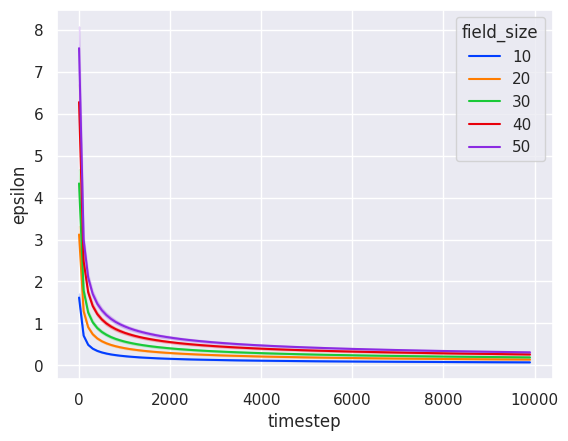

In [34]:
sns.set_theme(style="darkgrid")


# Plot the responses for different events and regions
sns.lineplot(x="timestep", y="epsilon", hue="field_size", data=df, palette="bright")

### 2.1
The number of runtime increases linearly with increasing number of battlefields, in accoradance with the complexity of the implemented algorithm (for a set number of iterations of fictious play).

In [23]:
import time
import numpy as np
runtimes = []
for f_size in range(10,200,10):
    for iter in range(20):
        ta = r.randint(1, f_size-2)
        td = r.randint(ta+1, f_size-1)
        field = np.random.randint(2,6,f_size)
        start = time.time()
        ficticiousPlay(field, ta, td, max_iters=max_iters, epsilon=0.0)
        end = time.time()
        runtimes.append((iter, f_size, end-start))

/tmp/ipykernel_1190329/2791304720.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x = 'num_fields', y='time (s)', data=df_times, palette="bright")


<Axes: xlabel='num_fields', ylabel='time (s)'>

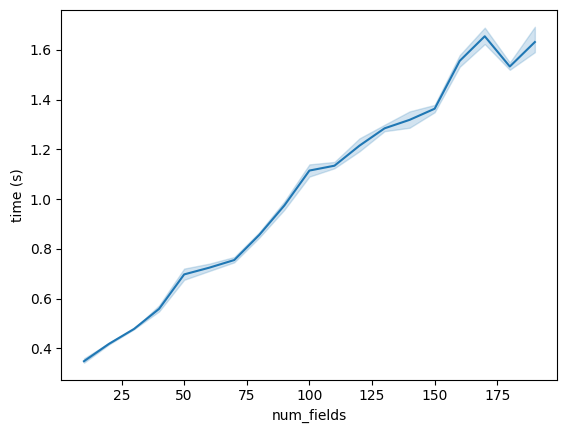

In [25]:
import seaborn as sns

df_times = pd.DataFrame(runtimes, columns=["iter", "num_fields", "time (s)"])

sns.lineplot(x = 'num_fields', y='time (s)', data=df_times, palette="bright")

### 2.3
The analysis of the achieved approximation of value of epsilon with respect to different starting strategies doesn't draw any interesting conclusions. There were 7 starting strategies checked:
1) no starting strategy (normal Fictitious Play)
2) uniform distributions over probabilities of which battlefield players assign a resource to
3) attackers starts with pure strategy picking bA least valueable battlefields, while defender bD most valueable
4) both players start with pure strategy picking bA or bD most valueable battlefields
5) defender starts with pure strategy picking bD least valueable battlefields, while attacker splits half of resources to each least and most valueable ones
6) attacker picks least valueable battlefield with probability 1 and distributes the rest uniformly over the rest of battlefields, defender does the same but picks most valueable battlefield
7) both players pick least valueable battlefield with probability 1 and distribute the rest uniformly over the rest of battlefields

First tests were done with 100000 rounds limit on random battlefields of size between 30 and 40 and there seemed to be no specific rule whatsoever. All approximations (in a scope of one test) with respect to starting strategy were better or worse comparing to no strategy depending on the test. There seemed to be a rule that "no strategy" strategy ended up with the worst approximation when difference of resources given to both players was over n / 2, but again, not for all tests.

The next approach was approximating epsilon for "no strategy" within 100000 rounds and checking how many rounds other starting strategies require to reach it. This time the number of checked battlefields was 10 and 45. The only tendency we could observe is that for mid and high tests, which operate on number of resources from range (n/3, 2n/3) and (2n/3, n) respectively, the number of required rounds was lower - sometimes by just few hundred, but in extreme case it was by 22000.

### 2.4
The equilibrium payoff is never negative for the attacker; even if he loses all battles, none of the battlefields have a negative value associated with them, so the payoff has a basline of zero. Thsi however is not achievable with the set $\{2,3,4,5\}$ for the battlefield values; as the defender cannot have a numebr of resources equal to the battlefields, so by asinging a non-zero probability to every battlefield, the attacker always has a non-zero chance that the defender will deploy no resources to one of the battlefields the attacker chose.

For the defender, again, by definition, his payoff is non-positive. The only way for it to be zero if for the atacker to lose all battles, for this to be the case, we have to relax the assumptions of either:
- Having battlefield values be a superset of $\{0,2,3,4,5\}$
- Allow the defender to have number of resources equal to the number of battlefields
In the first case, if the defender has enough resources to occupy all non-zero value battlefields then he can defend perfectly. In the second scenario this is always the case.

Let's check how this varies in more general cases, on the graph below the pairs of $\{"low", "mid", "high"\}^2$ represent the attacker and defender each having respectivelly $0-15\%, 40-60\%, 85-100\%$ as many resources to allocate, as there are battlefields. The scores are the mean of optimal response scores of the players.

In [47]:
column_names = ["score", "field_size", "range"]

def get_score_data():
    for i,  (fs, ta, td, ra, rd) in enumerate(input_params):
        battlefield = battlefields_arr[i][:fs]
        att_p = Player(ta, attack_strats_stacked[i, :fs])
        def_p = Player(td, defend_strats_stacked[i, :fs])
        resp_att = bestPureResponseAtt(att_p, def_p, battlefield)
        resp_def = bestPureResponseDef(att_p, def_p, battlefield)
        score = np.sum(resp_att * battlefield * (1 - defend_strats_stacked[i, :fs]))
        score += np.sum((1 - resp_def) * battlefield * attack_strats_stacked[i, :fs])
        score /= 2
        yield(score, fs, '-'.join((ra, rd)))


df = pd.DataFrame(get_score_data(), columns=column_names)

<Axes: xlabel='field_size', ylabel='score'>

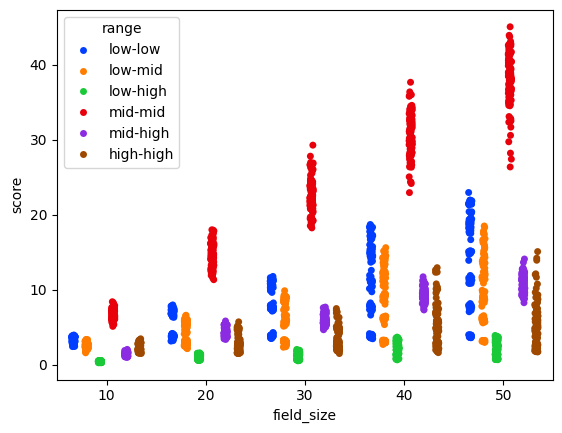

In [55]:
#sns.jointplot(data=df, x="field_size", y="score", hue="range", palette='bright')
sns.stripplot(data=df, x = 'field_size', y = 'score', hue="range", dodge=True, palette='bright')

We see that if both players have about half as many resources as there are battlefields, then the score can be maximised. This allows for many different allocations for the player, about $n \choose {n/2}$, whilsts still giving the defender the minimal amount of defence resources the rules of the game allow.

In other cases e.g. "low-low", even though the attacker has many options for resorce allocation, the cummulative score he can obtain is resticted because of the low amount of battlefields he can occupy; this is only exacerbated in the case "low-high" as the defender can block the attempts more effectively.

The case high-high is the most interesting in my opinion. It shows that even though the attacker has many resources, that means there is a small number of ways he can allcoate them so the defender has to only consider those few options and so can utilize his resources very effctivelly, resulting in the lowest scores in many cases.